#### Part2 튼튼한 GAN 만들기
---
Chapter 7. 손으로 쓴 숫자 훈련

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [4]:
class MnistDataset(Dataset):
  
  def __init__(self, csv_file):
    self.data_df = pandas.read_csv(csv_file, header=None)
    pass
  
  def __len__(self):
    return len(slef.data_df)

  def __getitem__(self, index):
    # 이미지 목표(레이블)
    label = self.data_df.iloc[index, 0]
    target = torch.zeros((10))
    target[label] = 1.0

    # 0-255의 이미지를 0-1로 정규화
    image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values) / 255.0

    # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
    return label, image_values, target
  
  def plot_image(self, index):
    img = self.data_df.iloc[index, 1:].values.reshape(28,28)
    plt.title("label = " + str(self.data_df.iloc[index, 0]))
    plt.imshow(img, interpolation='none', cmap='Blues')
    pass
  
  pass

In [5]:
# load data
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv')

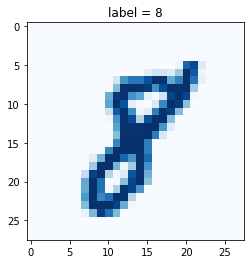

In [6]:
# check data contains images
mnist_dataset.plot_image(17)

In [7]:
class Discriminator(nn.Module):
  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()
    
    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(7844, 200),
        nn.Sigmoid(),
        nn.Linear(200, 1),
        nn.Sigmoid()
    )

    # 손실함수 설정
    self.loss_function = nn.MSELoss()
    
    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, inputs, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs)

    # 손실 계산
    loss = self.loss_function(outputs, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if(self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass
    
    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    
    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass
  pass

In [9]:
def generate_random(size):
  random_data = torch.rand(size)
  return random_data

In [10]:
D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
  # 실제 데이터
  D.train(image_data_tensor, torch.FloatTensor([1.0]))
  # 생성된 데이터
  D.train(generate_random(784), torch.FloatTensor([0.0]))
  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


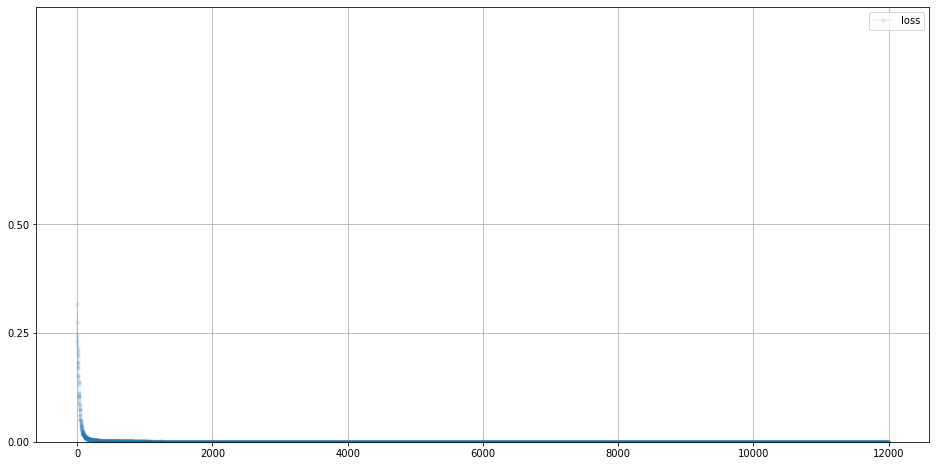

In [11]:
# plot discriminator loss
D.plot_progress()

In [12]:
# manually run discriminator to check it can tell real data from fake
for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
  print(D.forward(image_data_tensor).item())
  pass

for i in range(4):
  print(D.forward(generate_random(784)).item())
  pass

0.9966149926185608
0.9951796531677246
0.9918570518493652
0.9885380268096924
0.004455013200640678
0.008493487723171711
0.0045989034697413445
0.005497850477695465


In [13]:
class Generator(nn.Module):
  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(1, 200),
        nn.Sigmoid(),
        nn.Linear(200, 784),
        nn.Sigmoid()
    )

    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, D, inputs, targets):
    # 신경망 출력 계산
    g_output = self.forward(inputs)

    # 판별기로 전달
    d_output = D.forward(g_output)

    # 오차 계산
    loss = D.loss_function(d_output, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass
  pass

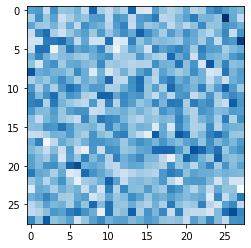

In [17]:
G = Generator()
output = G.forward(generate_random(1))
img = output.detach().numpy().reshape(28, 28)
plt.imshow(img, interpolation='none', cmap='Blues')

In [19]:
# 판별기 및 생성기 생성
D = Discriminator()
G = Generator()

# 판별기와 생성기 훈련
for label, image_data_tensor, target_tensor in mnist_dataset:
  # 참에 대해 판별기 훈련
  D.train(image_data_tensor, torch.FloatTensor([1.0]))

  # 거짓에 대해 판별기 훈련
  # G의 기울기가 계산되지 않도록 detach() 함수를 이용
  D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))

  # 생성기 훈련
  G.train(D, generate_random(1), torch.FloatTensor([1.0]))

  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


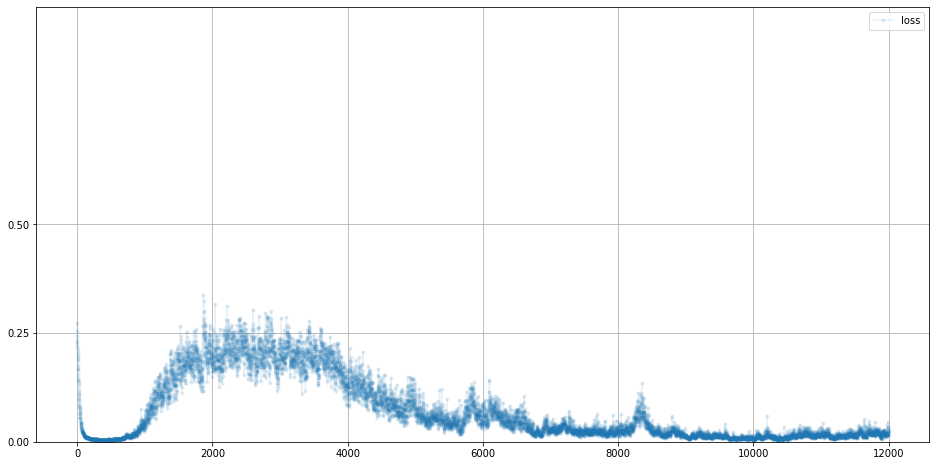

In [20]:
# plot discriminator error
D.plot_progress()

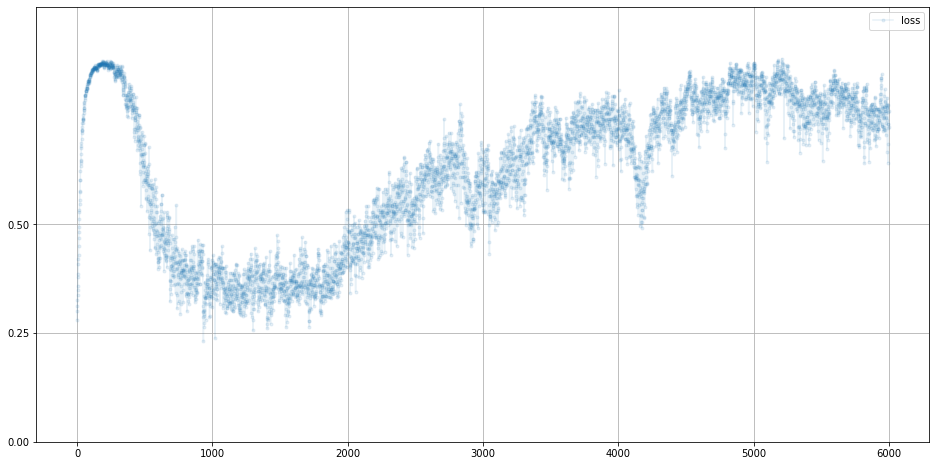

In [21]:
# plot generator error
G.plot_progress()

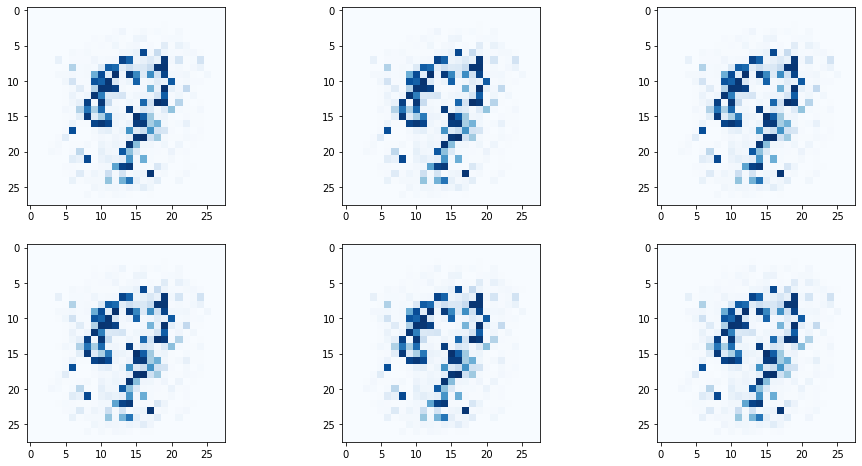

In [25]:
# 2행 3열로 생성된 이미지 출력
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random(1))
    img = output.detach().numpy().reshape(28,28)
    axarr[i, j].imshow(img, interpolation='none', cmap='Blues')
  pass
pass

---
모드붕괴

In [26]:
class Discriminator(nn.Module):
  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()
    
    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(784, 200),
        nn.LeakyReLU(9.92),

        nn.LayerNorm(200),

        nn.Linear(200, 1),
        nn.Sigmoid()
    )

    # 손실함수 설정
    self.loss_function = nn.BCELoss()
    
    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, inputs, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs)

    # 손실 계산
    loss = self.loss_function(outputs, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if(self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass
    
    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    
    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass
  pass

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(1, 200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 784),
        nn.Sigmoid()
    )

    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, D, inputs, targets):
    # 신경망 출력 계산
    g_output = self.forward(inputs)

    # 판별기로 전달
    d_output = D.forward(g_output)

    # 오차 계산
    loss = D.loss_function(d_output, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass
  pass

In [27]:
# 판별기 및 생성기 생성
D = Discriminator()
G = Generator()

# 판별기와 생성기 훈련
for label, image_data_tensor, target_tensor in mnist_dataset:
  # 참에 대해 판별기 훈련
  D.train(image_data_tensor, torch.FloatTensor([1.0]))

  # 거짓에 대해 판별기 훈련
  # G의 기울기가 계산되지 않도록 detach() 함수를 이용
  D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))

  # 생성기 훈련
  G.train(D, generate_random(1), torch.FloatTensor([1.0]))

  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


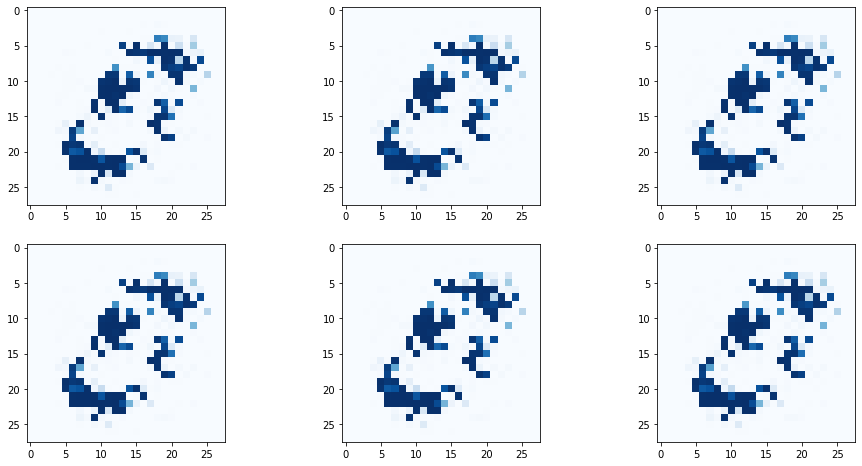

In [28]:
# 2행 3열로 생성된 이미지 출력
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random(1))
    img = output.detach().numpy().reshape(28,28)
    axarr[i, j].imshow(img, interpolation='none', cmap='Blues')
  pass
pass

In [40]:

# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [41]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [47]:
def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data
  
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

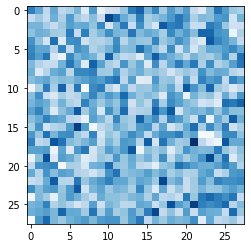

In [48]:
# check the generator output is of the right type and shape

G = Generator()

output = G.forward(generate_random_seed(100))

img = output.detach().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

In [49]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()

epochs = 4

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  for label, image_data_tensor, target_tensor in mnist_dataset:
    # train discriminator on true
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
    
    # train generator
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

    pass
    
  pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
CPU times: user 32min 53s, sys: 27.5 s, total: 33min 20s
Wall time: 33min 22s


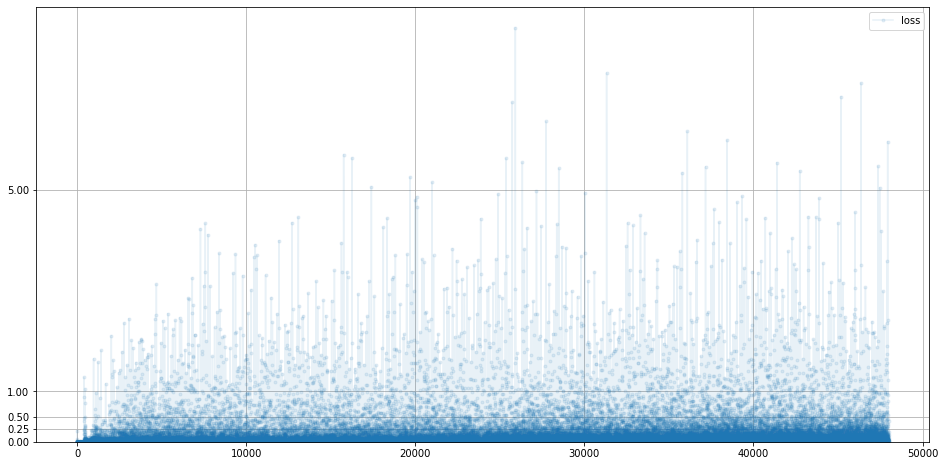

In [50]:
# plot discriminator error

D.plot_progress()

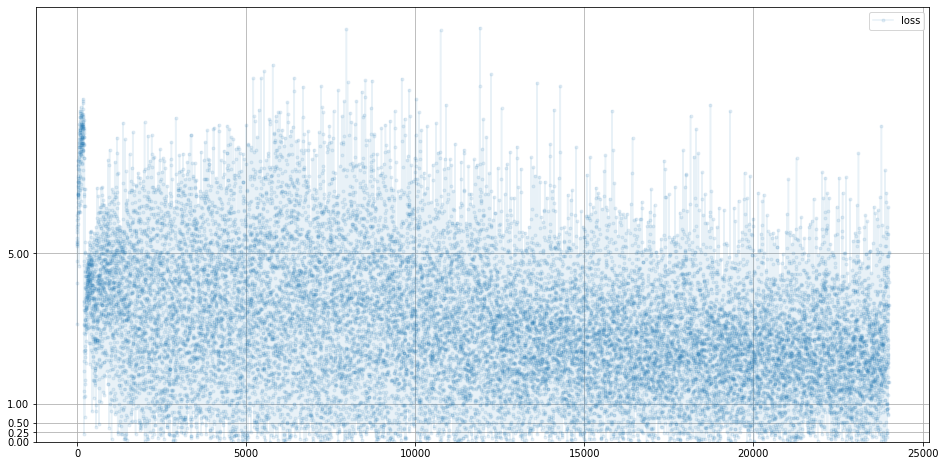

In [51]:
# plot generator error

G.plot_progress()


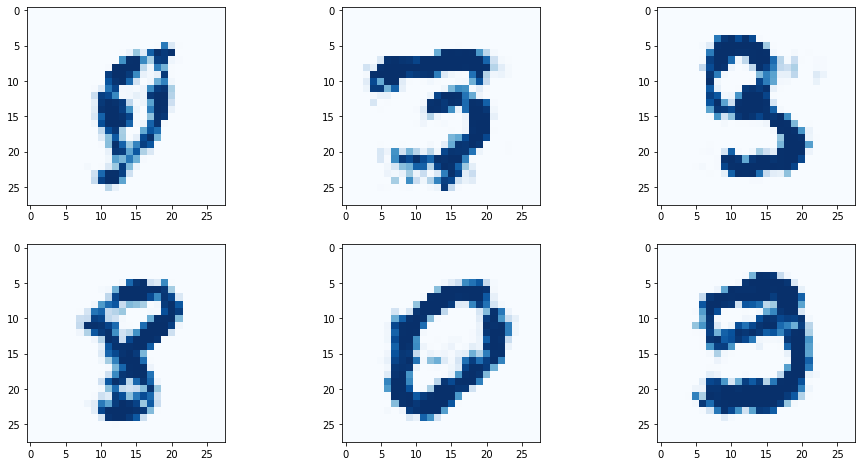

In [52]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

---

In [53]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [54]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [55]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()

epochs = 4

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  for label, image_data_tensor, target_tensor in mnist_dataset:
    # train discriminator on true
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
    
    # train generator
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

    pass
    
  pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
CPU times: user 32min 48s, sys: 28.2 s, total: 33min 17s
Wall time: 33min 17s


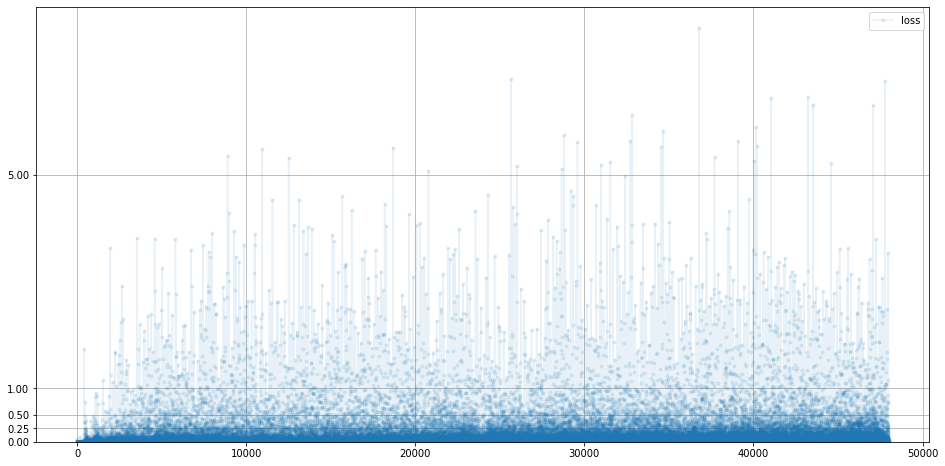

In [56]:
# plot discriminator error

D.plot_progress()

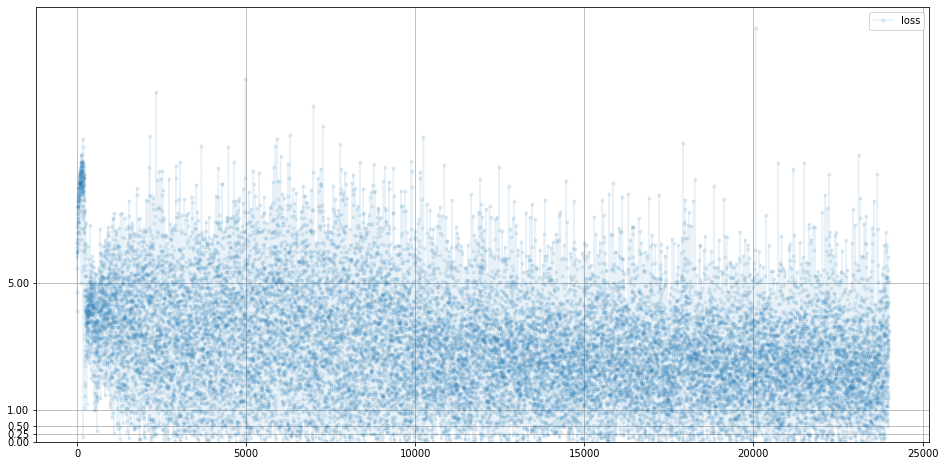

In [57]:
# plot generator error

G.plot_progress()

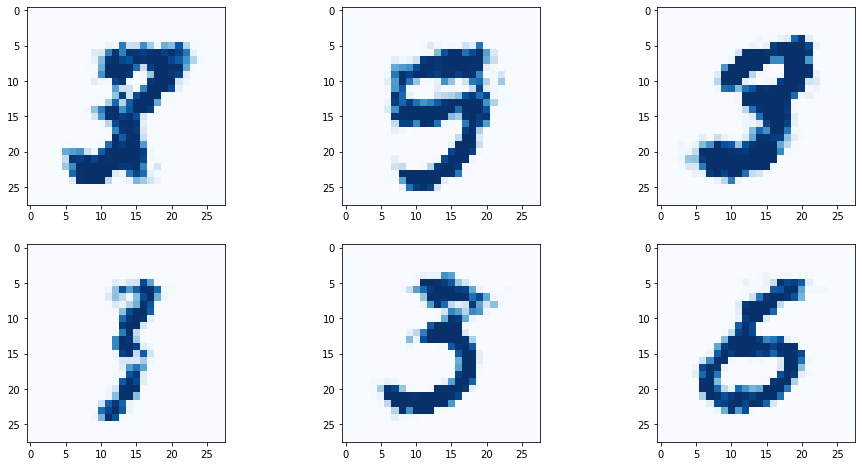

In [58]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

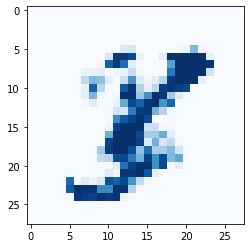

In [59]:
seed1 = generate_random_seed(100)
out1 = G.forward(seed1)
img1 = out1.detach().numpy().reshape(28,28)
plt.imshow(img1, interpolation='none', cmap='Blues')

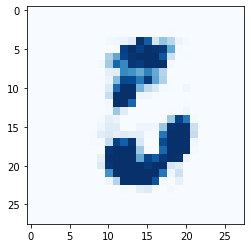

In [60]:
seed2 = generate_random_seed(100)
out2 = G.forward(seed2)
img2 = out2.detach().numpy().reshape(28,28)
plt.imshow(img2, interpolation='none', cmap='Blues')

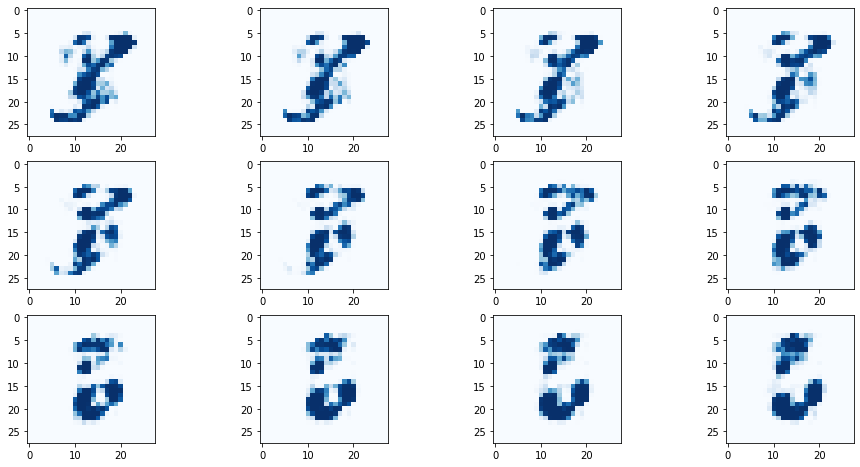

In [61]:
# plot several outputs from the trained generator

count = 0

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(3,4, figsize=(16,8))
for i in range(3):
    for j in range(4):
        seed = seed1 + (seed2 - seed1)/11 * count
        output = G.forward(seed)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        count = count + 1
        pass
    pass

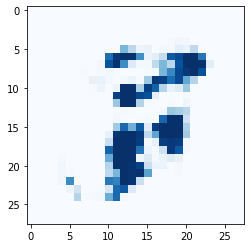

In [62]:
# sum of seeds

seed3 = seed1 + seed2
out3 = G.forward(seed3)
img3 = out3.detach().numpy().reshape(28,28)
plt.imshow(img3, interpolation='none', cmap='Blues')

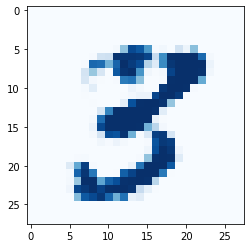

In [63]:

# difference of seeds

seed4 = seed1 - seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')

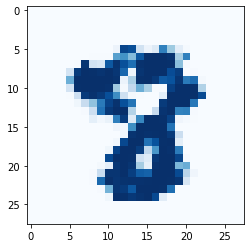

In [64]:
# difference of seeds

seed4 = seed1 * seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')